In [2]:
#check cuda version
import torch
print(torch.__version__)
print(torch.cuda.is_available())
print(torch.version.cuda)

2.2.0
True
12.1


In [3]:
import torch
from torch_geometric.data import Data


In [4]:
edge_index = torch.tensor([[0, 1],
                        [1, 0],
                        [1, 2],
                        [2, 1]], dtype=torch.long)
x = torch.tensor([[-1], [0], [1]], dtype=torch.float)

data = Data(x=x, edge_index=edge_index.t().contiguous())


In [6]:
import pandas as pd
import numpy as np


Creating Message Passing Networks

In [8]:
import networkx as nx
def pmfg(corr):
    """
    Constructs a PMFG from the correlation matrix specified

    Parameters
    -----------
    corr : array_like
        p x p matrix - correlation matrix

    Returns
    -------
    networkx graph
        The Planar Maximally Filtered Graph
    """
    vals = np.argsort(corr.flatten(), axis=None)[::-1]
    pmfg = nx.Graph()
    p = corr.shape[0]
    pmfg.add_nodes_from(range(p))
    for v in vals:
        idx_i, idx_j = np.unravel_index(v, (p, p))
        
        if idx_i == idx_j:
            continue

        pmfg.add_edge(idx_i, idx_j, weight=corr[idx_i, idx_j])
        if not nx.check_planarity(pmfg)[0]:
            pmfg.remove_edge(idx_i, idx_j)

        if len(pmfg.edges()) == 3 *  (p - 2):
            break

    return pmfg

In [9]:
price_df = pd.read_csv('close.csv',index_col=0)
market_df = pd.read_csv('market_equity_kospi.csv',index_col=0)

C:\Users\Lee Dong woo\AppData\Local\Temp\ipykernel_36760\708715122.py:1: DtypeWarning: Columns (2,4,10,13,14,15,18,19,20,23,27,28,29,31,33,36,37,45,46,47,49,52,53,56,58,59,60,63,65,66,67,69,72,73,75,76,77,81,82,83,84,86,94,95,97,102,103,104,106,108,109,110,113,114,116,119,121,122,123,124,125,127,130,134,136,139,142,146,152,155,156,159,160,161,163,164,165,166,167,168,170,171,173,176,177,179,180,181,182,185,187,188,191,192,193,195,196,197,198,202,203,204,208,211,213,215,216,217,218,222,223,225,228,233,234,235,236,238,240,241,244,247,248,249,250,251,252,253,260,264,266,268,272,273,274,278,280,281,282,283,285,288,289,290,291,292,294,300,301,304,307,308,311,312,313,315,316,317,318,321,328,329,331,332,333,336,344,345,348,350,351,353,359,361,362,363,365,366,367,368,369,371,372,373,374,375,376,377,379,381,382,383,385,386,387,388,389,391,392,397,398,403,405,406,408,409,411,413,415,416,420,425,427,431,434,435,438,441,444,445,447,448,449,450,459,460,462,466,468,469,470,471,473,474,475,478,482,484

In [10]:
print(len(price_df)-len(market_df))

-2486


In [43]:
market_df.index[-5]

'2022-11-07'

In [53]:
target_date

Timestamp('2022-11-09 00:00:00')

In [63]:
#get price_df's index as datetime
price_df.index = pd.to_datetime(price_df.index)

In [64]:
top_30_market_cap = market_df.iloc[-5, :].sort_values(ascending=False).index[:30].tolist()

# market_df에서 상위 30개 종목에 대한 데이터 추출
market_df_top_30 = market_df.loc[:, top_30_market_cap]

# market_df의 마지막에서 5번째 날짜 가져오기
target_date = pd.to_datetime(market_df.index[-5])


# price_df에서 해당 날짜의 index 가져오기
target_date_idx = price_df.index.get_loc(target_date)
# price_df에서 해당 날짜와 과거 5일치 데이터 가져오기




In [72]:
temp_df = price_df.iloc[target_date_idx-5:target_date_idx,:]

In [91]:
label_df = price_df.iloc[target_date_idx-5:target_date_idx+1,:]

label_df = label_df[top_30_market_cap]
label_df = label_df.applymap(lambda x: float(x.replace(',','')))

#if the price has risen, label 1, otherwise 0
price_difference = label_df.iloc[-1] - label_df.iloc[0]

# Create a binary label where 1 indicates a price increase and 0 indicates no increase or a decrease
labels = (price_difference > 0).astype(int)

print(labels)



A005930    1
A373220    1
A000660    1
A207940    1
A006400    1
A051910    1
A005380    1
A035420    0
A000270    1
A068270    0
A005490    1
A028260    1
A035720    0
A012330    1
A105560    0
A055550    1
A096770    1
A003670    1
A034730    1
A066570    1
A032830    0
A033780    0
A003550    1
A086790    0
A010130    0
A017670    1
A015760    1
A010950    1
A329180    1
A034020    1
dtype: int32


C:\Users\Lee Dong woo\AppData\Local\Temp\ipykernel_36760\2140777816.py:4: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  label_df = label_df.applymap(lambda x: float(x.replace(',','')))


In [92]:
labels

A005930    1
A373220    1
A000660    1
A207940    1
A006400    1
A051910    1
A005380    1
A035420    0
A000270    1
A068270    0
A005490    1
A028260    1
A035720    0
A012330    1
A105560    0
A055550    1
A096770    1
A003670    1
A034730    1
A066570    1
A032830    0
A033780    0
A003550    1
A086790    0
A010130    0
A017670    1
A015760    1
A010950    1
A329180    1
A034020    1
dtype: int32

In [80]:
real_df = temp_df[top_30_market_cap]

In [89]:
real_df

,A005930,A373220,A000660,A207940,A006400,A051910,A005380,A035420,A000270,A068270,...,A032830,A033780,A003550,A086790,A010130,A017670,A015760,A010950,A329180,A034020
2022-10-31,59400.0,528000.0,82700.0,877000.0,737000.0,626000.0,164500.0,169500.0,66300.0,184949.0,...,67400.0,95700.0,79200.0,41250.0,640000.0,50100.0,16750.0,86400.0,109000.0,13250.0
2022-11-01,60000.0,563000.0,83900.0,882000.0,760000.0,695000.0,164500.0,170500.0,66300.0,179169.0,...,67600.0,92400.0,81400.0,41300.0,626000.0,50200.0,17200.0,87300.0,110000.0,15850.0
2022-11-02,59600.0,569000.0,84500.0,873000.0,725000.0,672000.0,165000.0,174000.0,66200.0,180614.0,...,67300.0,94500.0,81100.0,41200.0,621000.0,50300.0,16750.0,91900.0,112000.0,14400.0
2022-11-03,59200.0,589000.0,82700.0,870000.0,739000.0,683000.0,162000.0,169000.0,64500.0,178206.0,...,66800.0,93900.0,80800.0,40850.0,586000.0,50400.0,16700.0,89700.0,111000.0,14950.0
2022-11-04,59400.0,592000.0,84500.0,871000.0,733000.0,690000.0,163000.0,174000.0,65300.0,177243.0,...,67500.0,96200.0,80600.0,40750.0,579000.0,50600.0,16850.0,91800.0,116500.0,14900.0


In [82]:
#make all values to be float of real_df. remove comma from values and make it to be float
real_df = real_df.applymap(lambda x: float(x.replace(',','')))


C:\Users\Lee Dong woo\AppData\Local\Temp\ipykernel_36760\2603130924.py:2: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  real_df = real_df.applymap(lambda x: float(x.replace(',','')))


In [83]:
# correlation 계산
correlation_matrix = real_df.corr()


In [84]:
correlation_matrix

,A005930,A373220,A000660,A207940,A006400,A051910,A005380,A035420,A000270,A068270,...,A032830,A033780,A003550,A086790,A010130,A017670,A015760,A010950,A329180,A034020
A005930,1.000000,-2.283095e-01,4.565217e-01,0.842701,0.628576,0.323022,0.669894,0.155761,0.707729,-0.010583,...,0.709243,-0.636355,0.512167,0.681678,0.508463,-0.394215,0.892805,-0.271557,-0.232505,0.518613
A373220,-0.228309,1.000000e+00,4.065961e-01,-0.626636,-0.136683,0.836202,-0.676569,0.379992,-0.744342,-0.958154,...,-0.350384,-0.060254,0.648782,-0.793569,-0.923251,0.899019,-0.047888,0.758283,0.727058,0.634798
A000660,0.456522,4.065961e-01,1.000000e+00,-0.026752,-0.207836,0.536787,0.341515,0.934568,0.275685,-0.458132,...,0.550457,0.063417,0.570368,-0.072101,-0.193937,0.462774,0.324657,0.674976,0.674830,0.388526
A207940,0.842701,-6.266358e-01,-2.675241e-02,1.000000,0.758716,-0.101571,0.650613,-0.285439,0.762072,0.385528,...,0.657858,-0.538889,0.050136,0.824764,0.754994,-0.727688,0.799052,-0.738251,-0.586203,0.194238
A006400,0.628576,-1.366828e-01,-2.078355e-01,0.758716,1.000000,0.324137,0.019909,-0.529808,0.163590,-0.123435,...,0.303612,-0.722298,0.285450,0.349241,0.223503,-0.347711,0.846937,-0.665795,-0.418519,0.607081
A051910,0.323022,8.362020e-01,5.367868e-01,-0.101571,0.324137,1.000000,-0.360932,0.322234,-0.385724,-0.944707,...,0.008096,-0.476293,0.899568,-0.399963,-0.623583,0.621720,0.487728,0.485270,0.507438,0.944499
A005380,0.669894,-6.765686e-01,3.415145e-01,0.650613,0.019909,-0.360932,1.000000,0.278250,0.974582,0.598122,...,0.652400,-0.120238,-0.042199,0.867328,0.851809,-0.652438,0.318765,-0.239020,-0.363201,-0.247331
A035420,0.155761,3.799918e-01,9.345682e-01,-0.285439,-0.529808,0.322234,0.278250,1.000000,0.187146,-0.337916,...,0.415509,0.372635,0.333608,-0.210316,-0.254831,0.539283,-0.012642,0.797563,0.763170,0.092937
A000270,0.707729,-7.443419e-01,2.756852e-01,0.762072,0.163590,-0.385724,0.974582,0.187146,1.000000,0.623898,...,0.759374,-0.104305,-0.129255,0.872163,0.873690,-0.684517,0.430149,-0.386978,-0.383188,-0.232107
A068270,-0.010583,-9.581541e-01,-4.581325e-01,0.385528,-0.123435,-0.944707,0.598122,-0.337916,0.623898,1.000000,...,0.156409,0.223596,-0.746287,0.677897,0.845244,-0.826153,-0.235957,-0.614760,-0.677159,-0.812162


In [86]:
#make correlation matrix to array
correlation_array = correlation_matrix.to_numpy()
correlation_graphs = pmfg(correlation_array)

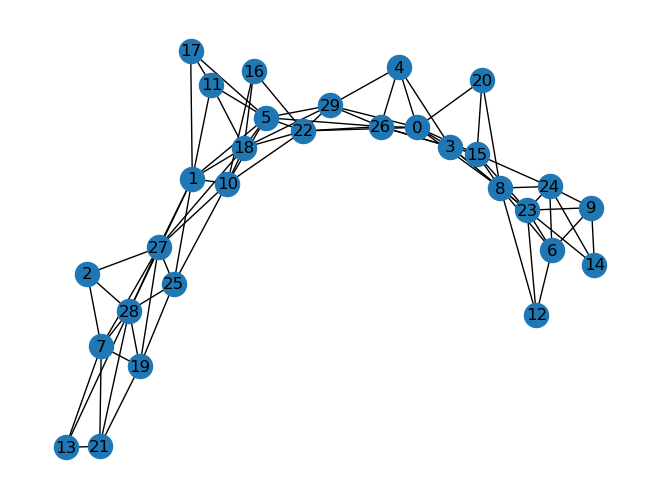

In [88]:
#visualize the graph
import matplotlib.pyplot as plt
nx.draw(correlation_graphs, with_labels=True)

In [95]:
#get the networkx graph to pytorchgeometric data class
import torch
from torch_geometric.data import Data
edge_index = torch.tensor(list(correlation_graphs.edges()), dtype=torch.long).t().contiguous()
x = torch.tensor(correlation_array, dtype=torch.float)
y = torch.tensor(labels, dtype=torch.float)
data = Data(x=x, edge_index=edge_index,y=y)


C:\Users\Lee Dong woo\AppData\Local\Temp\ipykernel_36760\2042392225.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y = torch.tensor(labels, dtype=torch.float)


In [97]:
data.num_node_features


30

In [98]:
# apply gcn model to get the labels: 1 or 0
import torch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

class GCN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, output_dim)
        self.fc = nn.Linear(output_dim, 1)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        # 첫 번째 Graph Convolutional Layer
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)

        # 두 번째 Graph Convolutional Layer
        x = self.conv2(x, edge_index)

        # 그래프 수준의 특성을 계산하기 위해 그래프 풀링
        x = torch.sum(x, dim=0, keepdim=True)

        # Fully Connected Layer
        x = self.fc(x)

        return torch.sigmoid(x)



device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GCN(input_dim=30, hidden_dim=10, output_dim=30).to(device)
data = data.to(device)
model(data)


tensor([[0.6099]], device='cuda:0', grad_fn=<SigmoidBackward0>)

use ohlcv로 진행하자. 그러면 된다.
데이터셋 구축하고 학습 진행하자.
